#### **COMP5329 – Deep Learning - Assignment 1**
Team members: vyun8699 (SID: 530454874), gzha9095 (SID:  500543568)  

Note: Please consult the attached report for experiment strategy and design and the readme.txt for overview of this file.


### **Imports**
Performance of this model is mainly measured by three criterias:
- **convergence speed (runtime)**: we prefer models that are able to converge faster.
- **Test accuracy score**: We want to optimize test accuracy as a general measure of performance.
- **Test weighted F1 score**: We want to make sure the F1 score (which is a combination of the Precision and Recall of all classes) is representable, ideally not significantly lower than our accuracy.

In [46]:
#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, f1_score 

### **Exploratory Data Analysis**
- Dimensions of training and test data shown below
- Data appears to be distributed equally among classes
- Variance of the 128-floating figures for each class appear to be concentrated to early digits (e.g. between digit 0 and 20) while later digits are sparse / close to 0.

In [47]:
# load dataset
original_train_data = np.load('Assignment1-Dataset/train_data.npy')
original_train_label = np.load('Assignment1-Dataset/train_label.npy')
original_test_data = np.load('Assignment1-Dataset/test_data.npy')
original_test_label = np.load('Assignment1-Dataset/test_label.npy')

#print dimensions
print(f'Dimension of training data: {original_train_data.shape}, training label: {original_train_label.shape}')
print(f'Dimension of test data: {original_test_data.shape}, test label: {original_test_label.shape}')

Dimension of training data: (50000, 128), training label: (50000, 1)
Dimension of test data: (10000, 128), test label: (10000, 1)


class 0: count: 5000, min:-22.08, max:25.58, med:0.01, std:1.26
class 1: count: 5000, min:-22.07, max:24.18, med:-0.01, std:1.24
class 2: count: 5000, min:-21.40, max:25.30, med:-0.00, std:1.09
class 3: count: 5000, min:-21.73, max:23.17, med:-0.00, std:1.22
class 4: count: 5000, min:-21.82, max:21.92, med:-0.00, std:1.02
class 5: count: 5000, min:-19.03, max:23.18, med:-0.00, std:1.19
class 6: count: 5000, min:-23.42, max:23.64, med:-0.00, std:1.09
class 7: count: 5000, min:-21.56, max:23.27, med:-0.00, std:1.14
class 8: count: 5000, min:-21.88, max:23.23, med:0.01, std:1.18
class 9: count: 5000, min:-22.77, max:22.20, med:-0.00, std:1.22


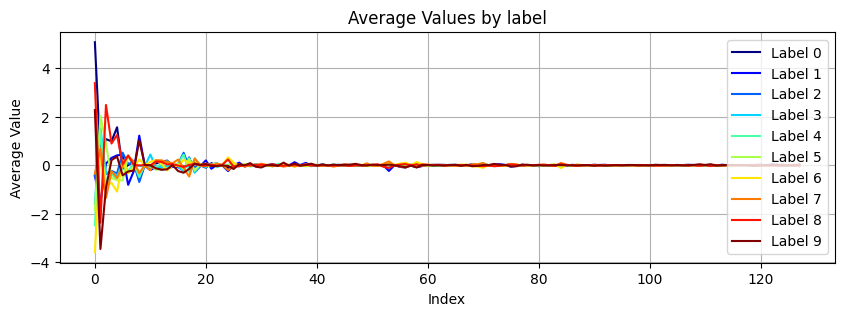

In [48]:
# training dataset is distributed equally
unique_values, counts = np.unique(original_train_label, return_counts = True)

collection = {}
    
for label in unique_values:
    label_indices = np.where(original_train_label == label)[0]
    class_data = original_train_data[label_indices]
    collection[label] = {'count': len(class_data),
                         'min': np.min(class_data),
                         'max': np.max(class_data),
                         'med': np.median(class_data),
                         'std': np.std(class_data),
                         'avg_val': np.mean(class_data, axis = 0)
    }

for label in unique_values:
    print(f'class {label}: count: {collection[label]["count"]}, min:{collection[label]["min"]:.2f}, max:{collection[label]["max"]:.2f}, med:{collection[label]["med"]:.2f}, std:{collection[label]["std"]:.2f}')

num_classes = len(collection)
colors = plt.cm.jet(np.linspace(0, 1, num_classes))  # Using the jet colormap, but you can choose others

plt.figure(figsize=(10, 3))
for i, (label, stats) in enumerate(collection.items()):
    avg_vals = stats['avg_val']  # Assuming this is a list of 128 average values
    indices = np.arange(len(avg_vals))  # Indices from 0 to 127
    plt.plot(indices, avg_vals, color=colors[i], label=f'Label {label}')

plt.title('Average Values by label')
plt.xlabel('Index')
plt.ylabel('Average Value')
plt.legend(loc='right')
plt.grid(True)
#plt.tight_layout()
plt.show()


### **Pre-processing**
- We normalize the data (with mean 0 and var 1) to aid the deep learning process
- We shuffle the dataset to aid generalization during training
- We split the training data into training and validation sets to allow validation checks during training (and implementation of early stopping)
- We did not do dimensionality reduction as sparsity is a feature useful in deep learning

In [49]:
# normalize dataset using train statistics
train_mean = np.mean(original_train_data)
train_std = np.std(original_train_data)
adj_train_data = (original_train_data - train_mean) / train_std
adj_test_data = (original_test_data - train_mean) / train_std

print(f'mean of adjusted train data: {np.mean(adj_train_data):.2f}, std dev: {np.std(adj_train_data):.2f}')

mean of adjusted train data: 0.00, std dev: 1.00


In [50]:
# resize and shuffle dataset

def resize_and_shuffle(input_data, input_label, proportion, random_state = None):
    '''
    (i) resizes dataset by multiplying against proportion (0 to 1) so we can work with smaller dataset during build process. 
    (ii) shuffle dataset to allow for better generalization during training.
    
    input:
    - input_data, input_label: array of data and label, to be zipped before resizing / reshuffling.
    - propotion: float, proportion of data to be used
    - random_state: int, seed for randomizer, used for replicability 
    
    output:
    - output_data, output_label: resized & shuffled data and label

    Example usage:
    - resize_and_shuffle(original_train_data, original_train_label), proportion = 1, random_state = 42)
    '''
    
    #instantiate output list
    output_data = []
    output_label = []
    
    #loop over unique labels and populate output lists
    unique_labels = np.unique(input_label)
    rs_generator = np.random.RandomState(random_state)
    
    for label in unique_labels:
        label_indices = np.where(input_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(proportion*len(label_indices)), replace=False)
        output_data.extend(input_data[selected_indices])
        output_label.extend(input_label[selected_indices])
    
    output_data = np.array(output_data)
    output_label = np.array(output_label)

    #reshuffle data because for some reason everything is grouped by class again
    shuffled_indices = np.arange(len(output_data))
    rs_generator.shuffle(shuffled_indices)
    output_data = output_data[shuffled_indices]
    output_label = output_label[shuffled_indices]
    
    #print output
    print(f'RESIZE AND SHUFFLE  >>> random_state: {random_state},  shape of data: {output_data.shape}')
    
    return output_data, output_label

In [51]:
# Create train and validation data 

def train_val_split(input_data, input_label, proportion = 0.8, random_state = None):
    '''
    train val split by a value of (proportion : 1-proportion) and shuffle again
    
    input:
    - input_data, input_label: array of train data and label, to be zipped together before train-val split
    - propotion: float, proportion of data to be assigned in train
    - random_state: seed for randomizer, use for replicability 
    
    output:
    - train_data, train_label: shuffled data and label assigned to training, has (proportion * input) data points
    - val_data, val_label: shuffled data and label assigned to validation, has ((1 - proportion) * input) data points
    
    Notes:
    - pairs of (output_data, output_label) will still match as the index used is matched
    
    Example command:
    - 80:20 train val split >>> train_val_split(train_data, train_label), proportion = 0.8, random_state = 42)
    '''
    #instantiate output lists
    train_data, train_label, val_data, val_label = [],[],[],[]

    #loop over unique labels and populate output lists
    unique_labels = np.unique(input_label)
    rs_generator = np.random.RandomState(random_state)

    for label in unique_labels:
        label_indices = np.where(input_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(proportion * len(label_indices)), replace=False)
        
        # populate lists. Anything that doesn't go to train, goes to val
        train_data.extend(input_data[selected_indices])
        train_label.extend(input_label[selected_indices])
        val_indices = np.setdiff1d(label_indices, selected_indices)
        val_data.extend(input_data[val_indices])
        val_label.extend(input_label[val_indices])

    #create arrays
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    val_data = np.array(val_data)
    val_label = np.array(val_label)

    # shuffle train data again for good measure
    train_shuffle_indices = np.arange(len(train_data))
    rs_generator.shuffle(train_shuffle_indices)
    train_data = train_data[train_shuffle_indices]
    train_label = train_label[train_shuffle_indices]
    
    # shuffle val data  again for good measure
    val_shuffle_indices = np.arange(len(val_data))
    rs_generator.shuffle(val_shuffle_indices)
    val_data = val_data[val_shuffle_indices]
    val_label = val_label[val_shuffle_indices]
    
    #prints
    print(f'TRAIN AND VAL SPLIT >>> random_state: {random_state}, shape of train: {train_data.shape}, shape of val: {val_data.shape}')
    print('') 
    return train_data, train_label, val_data, val_label

RESIZE AND SHUFFLE  >>> random_state: 42,  shape of data: (20000, 128)
TRAIN AND VAL SPLIT >>> random_state: 42, shape of train: (16000, 128), shape of val: (4000, 128)



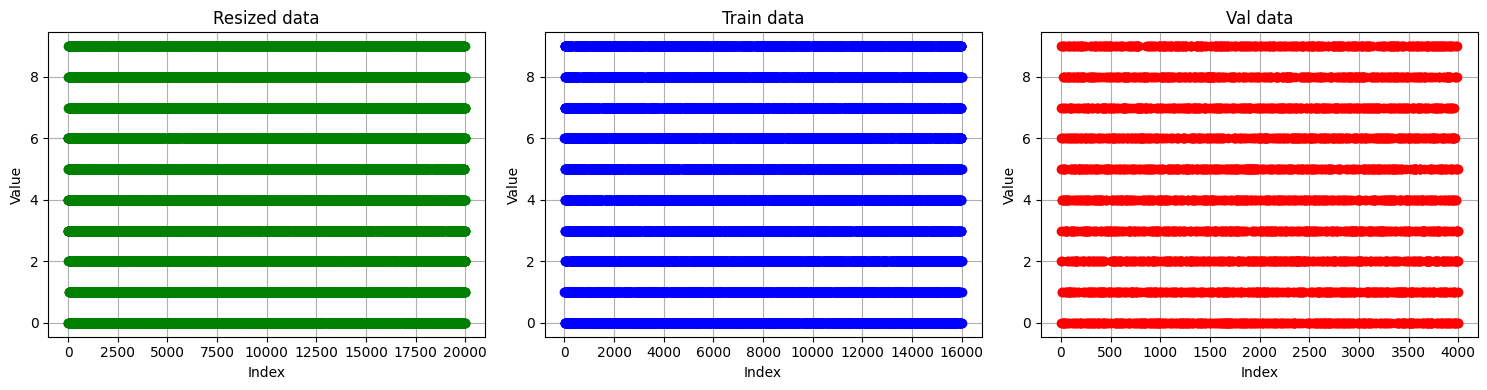

In [52]:
# Visually inspect the size and split of train and val data
# We want the labels to be spread uniformly amongts classes

# test resize_and_shuffle and train_val_split
data_proportion = 0.4 # 0.4 x 50,000 = 20,000
train_proportion = 0.8 # 0.8 x 20,000 = 16,000 in train_data
random_state = 42
input_check, output_check = resize_and_shuffle(adj_train_data, original_train_label, proportion = data_proportion, random_state = random_state)
train_data_check, train_label_check, val_data_check, val_label_check =train_val_split(input_check, output_check, proportion = train_proportion, random_state = 42)

# plot results, as long as data seems spread well, then the function works
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 2 columns

# Plot for training data
axs[0].plot(output_check, marker='o', linestyle ='', color = 'green')
axs[0].set_title('Resized data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].grid(True)

# Plot for training data
axs[1].plot(train_label_check, marker='o', linestyle ='', color = 'blue')
axs[1].set_title('Train data')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].grid(True)

# Plot for validation data
axs[2].plot(val_label_check, marker='o', linestyle ='', color = 'red')
axs[2].set_title('Val data')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Value')
axs[2].grid(True)

plt.tight_layout()
plt.show()

#### **Deep Learning Model**
The implementation of our model is divided into 3 classes:
- **Activation**: contain all activation functions and their derivatives.
- **HiddenLayer**: contain parameters of the layer, forward and backward passes, and methods.
- **MLP**: is the wrapper for our deep learning model. MLP calls on HiddenLayer and Activation and instantiates our input, hidden layer(s), and output layer as specified. 

In [53]:
class Activation(object):
    
    '''
    Activation objects and their derivatives used in our MLP. This class contains:
    - For hidden layers: tanh, sigmoid, relu, leaky relu
    - For output layer: softmax for multiclass classification

    Example usage:
    - Activation("relu") which loads relu and relu_deriv for activation and gradient calculation in the hidden layer
    '''
    #tanh
    def __tanh(self, x):
        return np.tanh(x)
    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    
    #sigmoid/logistic
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #relu
    def __relu(self, x):
        if np.isnan(x).any() or np.isinf(x).any():
            print("Detected NaN or Inf in x at relu")
        return np.maximum(0,x)
    def __relu_deriv(self, a):
        return np.where(a>0,1,0)
    
    #leaky relu
    def __lrelu(self,x):
        return np.maximum(0.01*x,x)
    
    def __lrelu_deriv(self, a):
        return np.where(a>0,1,0.01)
    
    #softmax
    def __softmax(self,x, eps=1e-9): 
        ''' 
        softmax is applied to the output layer to calculate probabilities of each classes.
        argmax of exponential calculation is used in MLP to pick the predicted class with highest probability in the softmax layer.
        np.max is subtracted from the exponential calculation to guard against overflow issue.
        Thus the largest value of the exponential calculation is exp(0) = 1
        '''
        if np.isnan(x).any() or np.isinf(x).any():
            print("Detected NaN or Inf in x at softmax")
        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        
        return exps / np.sum(exps, axis =-1, keepdims = True) + eps

    def __softmax_deriv(self,yhat, y_one_hot):
        '''
        gradient is approximated as the difference of predicted and true values.
        softmax gradient is not used in this model as softmax is only called in the output layer.
        '''
        return yhat - y_one_hot 

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'lrelu':
            self.f = self.__lrelu
            self.f_deriv = self.__lrelu_deriv

In [54]:
class HiddenLayer(object):    
    
    '''
    Hidden layer objects for our MLP. This class contains:
    - forward: forward propagation of input through linear transformation and activation in every layer
    - backward: backward propagation of errors/loss to calculate gradients, to be used in update (housed in the MLP class)
    - momentum: acceleration term to help escape saddle points (or very small gradients) on the objective curve
    - weight decay: penalty to the growth of weights in update (housed in MLP class) to avoid overfitting
    - dropout: assigns a mask with value 1 of probability (1-proportion), effectively retains / turns off nodes in layers during training
    - batchnorm_forward: application of batch normalization in forward propagation
    - batchnorm_backward: application of batch normalization in backward propagation

    Example command:
    - relu layer with 10 and 5 dimension input and output >>> HiddenLayer(10, 5, activation="relu")
    '''
    
    def __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None, batch_size = 1, batchnorm_switch = True):
        """
        Fully connected hidden layer with default relu activation, overwrittable when HiddenLayer is called.

        Input:
        - n_in: number of nodes in input.
        - n_out: number of nodes in output.
        - activation_last_layer: activation in output layer, default 'Softmax'.
        - activation: activation in input layer, default 'relu'.
        - W: weights of activation function, initialized with Xavier normalized initiation.
        - b: bias of activation function, initialized as zeros.
        - batch_size: int, size of batch size, use batch_size = 1 for SGD, batch_size = n for mini-batch, batch_size = len(input) for batch.
        - batchnorm_switch: boolean, default True, switch for batch normalization.
        
        NOTE: initialized parameters in __init__ which are not stated at the head of the __init__ function are explained with #comments below.
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # Set Weight to small values
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )


        # Set bias to zero, dimension to match output 
        self.b = np.zeros(n_out,)
        
        # we set the size of weight and bias gradients
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        #initialize momentum to zero, match size to weight and bias
        self.V_W = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)

        #initialize dropout mask to None
        self.dropout_mask = None

        #initialize parameters for batch normalization (gamma = scale, beta = shift)
        self.gamma = None
        self.beta = None
        self.grad_gamma = None
        self.grad_beta = None
        self.running_mean = np.zeros((batch_size,n_out)) #running mean value for each layer, to be used in val and test
        self.running_var = np.zeros((batch_size,n_out)) #running var value for each layer, to be used in val and test
        self.cache = None

        #initialize adam (momentum and RMS prop)
        self.V_dW = np.zeros(self.W.shape)
        self.S_dW = np.zeros(self.W.shape)
        self.V_db = np.zeros(self.b.shape)
        self.S_db = np.zeros(self.b.shape)
 
    def forward(self, input, dropout_rate, is_train = True, batchnorm_switch = True):
        '''
        forward propagation of input to create output.
        In general the sequencing of forward is (i) linear transformation, (ii) batch normalization, (iii) dropout, (iv) activation function
        
        Input:
        - input: array, a symbolic tensor of shape (n_in,)
        - dropout_rate: float, portion of nodes to be excluded from each layer
        - is_train: boolean, default true, allows for differentiation between training and validation and testing runs, whereby weights and biases are only updated during training.
        - batchnorm_switch: boolean, default true, switch for batch normalization in hidden layers
        '''

        #linear transformation
        lin_output = np.dot(input, self.W) + self.b 
        
        #batchnorm
        if batchnorm_switch:
            lin_output = self.batchnorm_forward(lin_output, is_train)
            #print(f'shape of batchnorm output: {lin_output.shape}')

        self.output = lin_output

        #dropout
        self.dropout(is_train, dropout_rate)
        
        if self.activation:
            self.output = self.activation(self.output)
        
        self.input=input

        return self.output
    
    def backward(self, delta, batchnorm_switch):         
        '''
        backward propagation of output all the way back to input, and calculation of gradients along the way.
        In general the sequencing of backward is the opposite of forward (i) calculate grad_W and grad_b, (ii) dropout, (iii) batch normalization, (iv) linear transformation
        
        Input:
        - delta: gradient of objective function passed backwards from output layer, may or may not have gone through transformations.
        - batchnorm_switch: boolean, default true, switch for batch normalization in hidden layers.
        '''

        #gradient
        self.grad_W = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis = 0) 

        #dropout
        delta *= self.dropout_mask

        #batchnorm
        if batchnorm_switch:
            delta = self.batchnorm_backward(delta)

        #linear transformation
        if self.activation_deriv: 
            delta = np.dot(delta, self.W.T) * self.activation_deriv(self.input)

    
        return delta
    
    def momentum(self, momentum_gamma, lr):
        '''
        apply momentum term to SGD to help model escape saddle points.
        momentum adjusts velocity terms used in calculating gradient of weights and biases.

        Input:
        - momentum_gamma: float, between 0 and 1. momentum term
        - lr: float, between 0 and 1. learning rate
   
        '''
        self.V_W = momentum_gamma * self.V_W + lr * self.grad_W
        self.V_b = momentum_gamma * self.V_b + lr * self.grad_b 

    def weightdecay(self, lr, weight_decay):
        '''
        apply weight decay which is a generalization strategy to prevent overfitting by muting / dampening gradient of weight.
        Calculation is based on lecture 4 slide 10, bottom middle.

        Input:
        - lr: float, between 0 and 1, learning rate.
        - weight_decay: float, between 0 and 1, weight decay term.
        '''
        self.W += lr * (weight_decay * self.W)

    def dropout(self, is_train, dropout_rate):

        '''
        apply inverted dropout to hidden layer to keep weights representative of usable weights in deployment.
        
        Input:
        - is_train: boolean, default true, allows for differentiation between training and validation and testing runs, whereby weights and biases are only updated during training.
        - dropout_rate: float, proportion of nodes to be switched off by applying a boolean mask to be multiplied to nodes in layers during forward and backward pass.
        '''
        
        if is_train and dropout_rate > 0.0:
            self.dropout_mask = (np.random.rand(*self.output.shape) < (1 - dropout_rate))
            if np.isnan(self.dropout_mask).any() or np.isinf(self.dropout_mask).any():
                print("Detected NaN or Inf in dropout_mask in dropout")
            
        else:
            self.dropout_mask = np.ones_like(self.output)        

        self.output *= self.dropout_mask
        self.output *= 1/(1-dropout_rate)
    
    def batchnorm_forward(self,input, is_train = True, bn_momentum = 0.9, eps = 1e-9):
        '''
        Implementation of forward batch normalization, which normalizes input to combat covariate shift.
        Running mean is calculated with a momentum term to control the rate of update.

        Implementation of batchnorm_forward and batchnorm_backward are learnt from multiple outside sources, including:
        1. Yong, Hongwei & Huang, Jianqiang & Meng, Deyu & Hua, Xiansheng & Zhang, Lei. (2020). Momentum Batch Normalization for Deep Learning with Small Batch Size. 10.1007/978-3-030-58610-2_14. 
        2. Vinod, R. (2021, December 14). Batch Normalisation Explained - Towards Data Science. Medium. https://towardsdatascience.com/batch-normalisation-explained-5f4bd9de5feb#:~:text=Test%20phase,that%20is%20calculated%20during%20training.
        3. Kratzert, F. (2016, February 12). Understanding the backward pass through Batch Normalization Layer. https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
        
        Input:
        - input: array, input to BN layer, usually after linear transformation
        - is_train: boolean, default true, allows for differentiation between training and validation and testing runs, whereby weights and biases are only updated during training.
        - bn_momentum: batch normalization momentum term, used to control rate of update of the running mean and variance
        - eps: epsilon value, to combat overflow / underflow issue

        NOTE: self.gamma and self.beta are scaling and shift factors. These are learnable factors with default value of 1 and 0, respectively.

        Output: 
        - normalized array of same shape as input (mean ~0 var ~1)
        '''

        if self.gamma is None:
            self.gamma = np.ones((input.shape[-1]))
            self.beta = np.zeros((input.shape[-1]))
            self.grad_gamma = np.ones((input.shape))
            self.grad_beta = np.zeros((input.shape[-1]))

        if is_train:
            #calculate mean, variance, and normalized input
            batch_mean = np.mean(input, axis = 0)
            batch_var = np.var(input, axis = 0)
            batch_std = np.sqrt(batch_var + eps)
            input_centered = input - batch_mean
            input_normalized = input_centered/np.sqrt(batch_var + eps) #epsilon introduced to avoid divide by zero

            #use self.cache so values can be reused during backward pass
            self.cache = (input, input_normalized, batch_mean, batch_var)

            output = input_normalized * self.gamma + self.beta

            self.running_mean = bn_momentum * self.running_mean + (1-bn_momentum) * batch_mean
            self.running_var = bn_momentum * self.running_var + (1-bn_momentum) * batch_var

            self.cache = (input_normalized, input_centered, batch_std)

        else:
            input_normalized = (input - self.running_mean)/np.sqrt(self.running_var + eps)
            output = self.gamma * input_normalized + self.beta

        #print('')
        return output
    
    def batchnorm_backward(self, delta):
        
        '''
        Implementation of backward batch normalization, which calculates relevant gradients for batch normalization.
        Gradients are calculated w.r.t input, gamma, and beta.

        Implementation of batchnorm_forward and batchnorm_backward are learnt from multiple outside sources, including:
        1. Yong, Hongwei & Huang, Jianqiang & Meng, Deyu & Hua, Xiansheng & Zhang, Lei. (2020). Momentum Batch Normalization for Deep Learning with Small Batch Size. 10.1007/978-3-030-58610-2_14. 
        2. Vinod, R. (2021, December 14). Batch Normalisation Explained - Towards Data Science. Medium. https://towardsdatascience.com/batch-normalisation-explained-5f4bd9de5feb#:~:text=Test%20phase,that%20is%20calculated%20during%20training.
        3. Kratzert, F. (2016, February 12). Understanding the backward pass through Batch Normalization Layer. https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
        
        Input:
        - delta: gradient of objective function passed backwards from output layer, may or may not have gone through transformations.
        
        Note: 
        - parameters used in backward batch normalization was stored in self.cache, thus not called up top.
        - self.gamma and self.beta are scaling and shift factors. These are learnable factors with default value of 1 and 0, respectively.

        Output: 
        - dx which an array to be fed back through reverse linear transformation towards the input layer.
        '''

        #print('start bn backward')
        output_normalized, output_centered, batch_std = self.cache
        
        N,D = delta.shape
        
        #print(f'shape of delta:{delta.shape}')
        #print(f'shape of output_normalized: {output_normalized.shape}')
        self.grad_gamma = np.sum(delta * output_normalized, axis = 0)
        self.grad_beta = np.sum(delta, axis = 0)

        dx_normalized = delta * self.gamma
        dx_centered = dx_normalized / batch_std
        dmean = np.sum(-dx_centered, axis = 0) + 2/N * np.sum(output_centered, axis=0)
        dstd = np.sum((dx_normalized * output_centered * - batch_std**(-2)), axis = 0)
        dvar = dstd / 2/ batch_std
        dx = dx_centered + (dmean + dvar * 2 * output_centered) / N
        return dx
    
    def adam(self, iter, adam_learning_rate = 0.1, beta1 = 0.9, beta2 = 0.99, eps = 1e-9, adam_switch = True):
        '''
        Implementation of the adam optimizer which utilizes momentum and RMSprop to calculate the optimal weight and bias updates.

        Implementation of the adam optimizer is learnt from multiple outside sources, including:
        1. D. (2017, August 25). Adam Optimization Algorithm (C2W2L08). YouTube. https://www.youtube.com/watch?v=JXQT_vxqwIs
        2. Kingma, D. P., & Ba, J. (2014, December 22). Adam: A Method for Stochastic Optimization. arXiv.org. https://arxiv.org/abs/1412.6980

        Input:
        - iter: number of iteration, used to calculate correction to V and S.
        - adam_learning_rate: float, learning rate used in ADAM, to be tuned.
        - beta1: beta used to calculate momentum
        - beta2: beta used to calculate rms prop
        - eps: epsilon value, to combat overflow / underflow issue
        - adam_switch: boolean, his value will be automatically set to True if adam_learning_rate > 0.0

        Output:
        - adam_W: calculation of weights with adam optimizer
        - adam_b: calculation of bias with adam optimizer

        NOTE: when Adam optimizer is used, weight decay and momentum are overwritten/disabled. see MLP.update below.
        '''
        #momentum
        self.V_dW = beta1 * self.V_dW + (1-beta1) * self.grad_W
        self.V_db = beta1 * self.V_db + (1-beta1) * self.grad_b
        
        #rms prop
        self.S_dW = beta2 * self.S_dW + (1-beta2) * (self.grad_W ** 2)
        self.S_db = beta2 * self.S_db + (1-beta2) * (self.grad_b ** 2)
        
        #correction
        self.V_dW = self.V_dW / (1 - (beta1 ** iter))
        self.V_db = self.V_db / (1 - (beta1 ** iter))
        self.S_dW = self.S_dW / (1 - (beta2 ** iter))
        self.S_db = self.S_db / (1 - (beta2 ** iter))

        #calculate adjustments
        adam_W = adam_learning_rate * self.V_dW / (np.sqrt(self.S_dW)+eps)
        adam_b = adam_learning_rate * self.V_db / (np.sqrt(self.S_db)+eps)
        
        return adam_W, adam_b

In [55]:
class MLP:
    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        initialization of MLP, which is a wrapper for our deep learning model.
        
        Input:
        - layers: A list containing the number of units in each layer. Should be at least two values
        - activation: The activation function to be used

        Example usage:
        nn = MLP([128,64,10], [None, 'relu', 'softmax']) 
               >>> this produces a network which takes input sized 128, 
                   pass it through a relu layer with size 64, 
                   and then to a softmax layer with size 10.
        """

        # __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None, dropout_rate = 0.0)        
        ### initialize layers
        self.layers=[]
        self.params=[] # this doesnt do anything
        
        self.activation=activation
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:  # Check if it's the last hidden layer
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1], W=np.random.uniform(
                            low=-np.sqrt(6. / (layers[i] + layers[i + 1])),
                            high=np.sqrt(6. / (layers[i] + layers[i + 1])),
                            size=(layers[i], layers[i + 1])).T)
                self.layers.append(hidden_layer)
            else:
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])
                self.layers.append(hidden_layer)


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input, dropout_rate, batchnorm_switch, is_train = True):
        '''This function calls the forward function in HiddenLayer'''
        for layer in self.layers:
            output=layer.forward(input, dropout_rate, is_train, batchnorm_switch)
            input=output
        return output

    #implement cross entropy, mimic input and output of MSE
    def criterion_cross_entropy(self, y, y_hat, batch_size, eps=1e-9):
        '''
        objective function commonly used in multiclassification models, paired with softmax.
        Calculates the degree of 'error' between actual and predicted output

        Input:
        - y: true label
        - y_hat: predicted label
        - batch_size: number of data feed with getBatch (our loader)
        - eps: epsilon value, to combat overflow / underflow issue

        output:
        - loss: average loss value calculated via criterion cross entropy
        - delta: gradient calcualted from output layer, to be used in backward propagation.
        '''
        activation_deriv=Activation(self.activation[-1]).f_deriv
        
        #one hot encode y to match shape of y_hat, value is 0 everywhere, 1 for the positive column
        num_classes = y_hat.shape[1] 
        num_samples = y.shape[0]
        y_one_hot = np.zeros((num_samples,num_classes)) 
        y = y.flatten().astype(int)
        y_one_hot[np.arange(num_samples),y] = 1 

        # calculate loss, add epsilon to avoid log 0
        loss = np.sum(- y_one_hot * np.log(y_hat + eps)) /  batch_size #adjusting loss by batch_size for minibatch
        
        #calculate delta of output layer 
        delta = activation_deriv(y_hat, y_one_hot)

        #return loss and delta
        return loss, delta

    # backward progress  
    def backward(self,delta, batchnorm_switch):
        '''This function calls the backward function in HiddenLayer'''
        delta=self.layers[-1].backward(delta, batchnorm_switch)
        for layer in reversed(self.layers[:-1]): #self.layers[:-1] returns the list excluding the last element
            delta = layer.backward(delta, batchnorm_switch)


    def update(self,momentum_gamma,lr, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate):
        '''
        updates weights and biases with gradient calculated in forward and backward pass.
        Multiple methods are called here

        Input:
        - momentum_gamma: float, momentum coefficient.
        - lr: float, learning rate.
        - weight_decay: float, dampener coefficient for weight decay.
        - batchnorm_switch: boolean, switch for batch normalization
        - adam_switch: defaults to True when adam_learning_rate > 0
        - adam_learning_rate: float, learning rate used in adam optimizer, to be tuned.

        NOTE: when adam is implemented, weight_decay and momentum are automatically disabled to keep things clean.

        '''
        for layer in self.layers:
            assert layer.W.shape == layer.grad_W.shape, f'mismatch in W{layer.W.shape} and grad_W {layer.grad_W.shape} shapes'
            assert layer.b.shape == layer.grad_b.shape, f'mismatch in b {layer.b.shape} and grad_b shapes {layer.grad_b.shape}'
            
            #call momentum from HiddenLayer to update V values
            layer.momentum(momentum_gamma,lr)
            
            #call weightdecay from hiddenlayer to update V values
            layer.weightdecay(lr, weight_decay)

            #apply adjustments to V_W to W
            if adam_switch:
                self.adam_counter += 1
                adam_W, adam_b = layer.adam(self.adam_counter, adam_learning_rate = adam_learning_rate, beta1 = 0.9, beta2 = 0.99, eps = 1e-9, adam_switch = True)
                layer.W -= adam_W
                layer.b -= adam_b
            else:
                layer.W -= layer.V_W
                layer.b -= layer.V_b

            #batchnorm update
            if batchnorm_switch:
                layer.gamma -= lr * layer.grad_gamma
                layer.beta -= lr * layer.grad_beta

    '''minibatch added here. n = 1 is SGD, n = N is batch n = n is minibatch'''
    def getBatch(self, X,y, batch_size):
        
        '''
        performs minibatch

        Input:
        - X,y: data and label, to be zipped.
        - batch_size: int, between 1 and len(X):
                >>> batch_size 1 is SGD, 
                >>> batch_size len(x) is batch, 
                >>> everything in between is minibatch
        
        NOTE: the minibatch implementation drops last batch to ensure consistency/stability of training data fed to the model.
        '''
        #exceptions
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'length of data ({X.shape[0]}) not equal to length of label ({y.shape[0]})')
        if batch_size > X.shape[0]:
            raise ValueError(f'batch_size = {batch_size} > data count: {X.shape[0]}')
        
        #mini batch 
        if batch_size <= X.shape[0]:
            # for loop below drops the last batch, just in case it is too small
            for start_index in range(0, X.shape[0] - batch_size + 1, batch_size):
                end_index = min(start_index + batch_size, X.shape[0])
                yield X[start_index:end_index], y[start_index:end_index]


    def fit(self,X_train,y_train, X_val, y_val, momentum_gamma =0.9, learning_rate=0.1, epochs=100, batch_size =1, weight_decay = 0.01, dropout_rate = 0.0, early_stopping =[5,10], batchnorm_switch = True, adam_switch = True, adam_learning_rate = 0.1):
       
        '''
        Fit the model with training data.
        Validation check is done every early_stopping[1] epochs.
        Training is divided into two stages: 
           (i) stage 1: training is stopped when validation score has not improved for early_stopping[0] cycles.
           (ii) stage 2: training is then continued with training + validation data until loss score beats stage 1 or we reach maximum epoch.

        Input:
        - X_train, y_train: arrays, data and labels of training data.
        - X_val, y_val: arrays, data and labels of validation data.
        - momentum_gamma: float, see HiddenLayer.momentum()
        - learning_rate: float, learning rate
        - epochs: int, maximum epoch count
        - batch_size: int, size of batch, see self.getBatch()
        - weight_decay: float, see HiddenLayer.weightdecay()
        - dropout_rate: float, proportion of nodes to be deactivated, see HiddenLayer.dropout()
        - early_stopping: list, first element is the number of maximum cycles of non improvement before early stopping is triggered, second element is the number of epochs per validation cycle.
        - batchnorm_switch: boolean, see HiddenLayer.batchnorm_forward() and HiddenLayer.batchnorm_backward()
        - adam_switch: boolean, defaults to True if adam_learning_rate >0, see HiddenLayer.adam()
        - adam_learning_rate: float, learning rate for adam, see HiddenLayer.adam()
        
        Output:
        - epoch_losses: list, average training loss each epoch
        - val_losses: list, average val loss each (epoch/early_stopping[1])
        - epoch: int, number of last epoch, for reporting purposes

        NOTE: to keep self.fit() clean, we have prepared self.train_loop() which consists of a single forward, backward, and update pass.

        '''
        
        #check if train and val data were provided
        validate_check = len(X_val) > 0 and len(y_val) > 0
        if validate_check is False:
            print('No validation data provided, skipping validation step')

        #instantiate toggles for early_stopping
        is_early_stop = False
        last_validation_loss = float('inf') if validate_check else None
        epoch = 0
        count = 0
        MAX_COUNT = early_stopping[0]
        EVAL_TRIGGER = early_stopping[1]

        # assign X_train and y_train to X and y 
        X=np.array(X_train)
        y=np.array(y_train)
        epoch_losses = []
        val_losses = []
        
        #start adam_counter at 0
        self.adam_counter = 0

        #loop over epochs
        #print(f'FITTING (STAGE 1)   >>> training to be stopped when val score does not improve in {MAX_COUNT} cycles ({MAX_COUNT * EVAL_TRIGGER} epochs)')
       
        for k in range(epochs):
            #print(f'dropout rate in fit epoch {k}: {dropout_rate}')
            #print(f'start epoch {k}')
            epoch_loss = self.train_loop(X, y, batch_size, dropout_rate, momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate)
            epoch_losses.append(epoch_loss)

            #implement early stop
            if validate_check and k % EVAL_TRIGGER == 0:
                current_validation_loss = self.eval(X_val, y_val, dropout_rate, batchnorm_switch)
                
                if current_validation_loss > last_validation_loss:
                    count += 1

                    if count == MAX_COUNT:
                        #print(f'                    >>> early stopping at epoch {k}')
                        is_early_stop = True
                        early_stop_train_score = epoch_loss
                        break
                
                else:
                    last_validation_loss = current_validation_loss
                    count = 0

                if not is_early_stop:
                    val_losses.append(current_validation_loss)
                    
            epoch += 1

        if validate_check and is_early_stop:
            #print('FITTING (STAGE 2)   >>> Continuing training with train + val data')
            X_combined = np.concatenate((X_train, X_val))
            y_combined = np.concatenate((y_train, y_val))

            while epoch < epochs:
                epoch +=1
                epoch_loss = self.train_loop(X_combined, y_combined, batch_size, dropout_rate, momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate)
                epoch_losses.append(epoch_loss)
                
                if epoch_loss < early_stop_train_score:
                    #print(f'                    >>> training stopped at epoch {epoch} -- training loss achieved')
                    break
                #elif (epoch == epochs):
                    #print(f'                    >>> training stopped at epoch {epoch} -- maximum epochs achieved')
        #print(f'         >>> train loss:{epoch_losses[-1]:.2f}, val loss: {val_losses[-1]:.2f}' if len(val_losses) >0 else f'                    >>> train loss:{epoch_losses[-1]:.2f}, val loss: None')
        return epoch_losses, val_losses, epoch

    # define the prediction function
    def predict(self, x, dropout_rate, batchnorm_switch):
        '''
        perform predict with neural network
        
        Input:
        - x: input data
        - dropout_rate: float between 0 and 1, portion of nodes to be randomly deactivated
        - batchnorm_swith: boolean, turns on/off batch normalization

        Output:
        - output: set of predicted labels
        '''
        x = np.array(x)
        output = np.zeros((x.shape[0], 1))  # Prepare output array to store predicted class labels
        for i in np.arange(x.shape[0]):
            probabilities = self.forward(x[i, :],dropout_rate, batchnorm_switch, is_train = False)  # Get the softmax probabilities
            predicted_class = np.argmax(probabilities)  # Choose the class with the highest probability
            output[i] = int(predicted_class)  # Assign the predicted class to the output array
        return output
    
    def eval(self, X_val, y_val, dropout_rate,batchnorm_switch):
        '''
        Evaluation check during training.

        Input:
        - X_val, y_val: input data and label allocated for validation checks
        - dropout_rate: float between 0 and 1, portion of nodes to be randomly deactivated
        - batchnorm_swith: boolean, turns on/off batch normalization
        
        output:
        - validation loss
        ''' 
    
        #print('eval triggered')
        X_val = np.array(X_val)
        y_val = np.array(y_val)
        yhat_val = self.forward(X_val, dropout_rate, batchnorm_switch, is_train=False) # we don't use predict because it will cause issues in criterion cross entropy  
        #print('x')
        val_loss, _ = self.criterion_cross_entropy(y_val,yhat_val, len(y_val))
        #print('end of eval')
        return np.mean(val_loss)
    
    def train_loop(self, X, y, batch_size, dropout_rate, momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate):
        '''
        a single pass through of forward, backward, and update
        Input definitions can be viewed at __init__ function above.
        '''
        
        #spits out epoch loss
                    
        total_loss = 0 #sum up batch_losses for every epoch
        batches = 0 #count number of batches, e.g. 1,2,3,4
        #print('y')
        
        for X_batch, y_batch in self.getBatch(X,y,batch_size):
            #print('x')
            # forward pass
            y_hat = self.forward(X_batch, dropout_rate, batchnorm_switch, is_train = True)
            #print(y_hat.shape)
            
            # compute loss and gradient
            loss,delta=self.criterion_cross_entropy(y_batch,y_hat, batch_size)

            #backward pass
            self.backward(delta, batchnorm_switch)

            # update
            self.update(momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate)

            #record batch loss in batch losses
            batch_loss = np.mean(loss)
            batches += 1
            total_loss += batch_loss
            #print(f'batches:{batches}')
            
            #print(y_batch)
            #print(f'Epoch: {k}, batch: {batches}, X_batch dim: {X_batch.shape}, y_batch dim: {y_batch.shape}, loss: {loss}')

        epoch_loss = total_loss / batches

        return epoch_loss

#### **Helper functions**
These functions were prepared to generalize repeated workflows during build and reporting. In summary:
 - **plot_loss_train_val**: plot train and validation losses
 - **print_accuracy_f1**: print train and test accuracy and weighted F1 scores
 - **hyperparameter_testing**: do hyperparameter testing for a series of parameters
 - **filter_asset**: filter columns and rows of hyperparameter testing results and return a dataframe
 - **multi_plotter**: plot results of hyperparameter testing with customized color, line, and marker

In [56]:
# plot results and print scores

def plot_loss_train_val(train_losses, val_losses, val_loss_interval=10, show_val=True, fig_size=(10,3), title=None):
   """
   Plots the training and validation losses.

   input:
   - train_losses: List of training losses.
   - val_losses: List of validation losses.
   - val_loss_interval: Interval at which validation losses were calculated (default is 10).
   - show_val: toggle to include/exclude val_losses in plot
   - fig_size: default size of plot
   """
   epochs = range(1, len(train_losses) + 1)
   val_epochs = [i * val_loss_interval for i in range(1, len(val_losses) + 1)]

   plt.figure(figsize=fig_size)  

   plt.plot(epochs, train_losses, 'b-', label='Training loss')
   if show_val:
      plt.plot(val_epochs, val_losses, 'r-', label='Validation loss')
   if title:
      plt.title(title)
   else: plt.title('Training and Validation loss')
   plt.xlabel('Epochs')
   plt.ylabel('Training Loss')
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.show()


def print_accuracy_f1(train_label, train_predict, test_label, test_predict):

   """
    Calculate training and testing scores based on model

    input:
    - train_label: actual train labels
    - train_predict: predicted train labels
    - test_label: actual test labels
    - test_predict: predicted test labels

    output:
    - Accuracy and weighted F1 score for train
    - Accuracy and weighted F1 score for test
   """
   train_accuracy = accuracy_score(train_label, train_predict)
   train_f1 = f1_score(train_label, train_predict, average='weighted')
   test_accuracy = accuracy_score(test_label, test_predict)
   test_f1 = f1_score(test_label, test_predict, average='weighted')
   print(f'                    >>> train accuracy: {train_accuracy:.2f}, train weighted f1: {train_f1:.2f}')
   print(f'test scores   >>> test accuracy: {test_accuracy:.2f}, test weighted f1: {test_f1:.2f}')


def hyperparamater_testing(parameters):
    '''
    perform hyperparameter testing on the deep learning network
    
    input 'parameters' consists of:
    - learning_rates: list of floats. learning rates.
    - batch_sizes: list of integers. batch sizes.
    - early_stopping_combination: list of list. each item is a combination of maximum number of validation cycle and number of epochs between validation checks
    - epoch_counts: list of integers. maximum epoch count.
    - momentum_gammas: list of floats between 0 and 1. gamma factor in momentum.
    - weight_decays: list of floats between 0 and 1. decay factor for weight decay.
    - dropouts: list of floats between 0 and 1. proportion of nodes to be deactivated.
    - batchnorm_switches: list of booleans. True if batch normalization is used, False if otherwise.
    - adam_learning_rates: list of floats between 0 and 1. Learning rate used in Adam optimizer.
    - node_counts: list of lists. each list contains the number of nodes in each layer. 
    - node_activations: list of lists. each list contains strings for types of layers in the network. 
    
    output 'assets' contains:
    - all relevant statistics and paramaters used in reporting
    - train losses and validation losses used in charts
    '''
    
    learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations = parameters
    sumproduct = (len(learning_rates) * len(batch_sizes) * len(early_stopping_combination) * len(epoch_counts) * len(momentum_gammas) * len(weight_decays) * len(dropouts) * len(batchnorm_switches) * len(adam_learning_rates) * len(node_counts))
    print(f'Running {sumproduct} cases.')
    
    assets = []
    counter = 0
    for early_stopping in early_stopping_combination:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                for epoch_count in epoch_counts:
                    for momentum_gamma in momentum_gammas:
                        for weight_decay in weight_decays:
                            for dropout in dropouts:
                                for batchnorm_switch in batchnorm_switches:
                                    for adam_learning_rate in adam_learning_rates:
                                        
                                        if adam_learning_rate > 0:
                                            adam_switch = True
                                        else: adam_switch = False

                                        for (node_count, node_activation) in zip(node_counts, node_activations):
                                            
                                            nn = MLP(node_count, node_activation)

                                            start_time = time.time()

                                            train_loss, val_loss, epoch = nn.fit(train_data, train_label, val_data, val_label, 
                                                            momentum_gamma = momentum_gamma, learning_rate = lr, 
                                                            epochs = epoch_count, batch_size = batch_size, 
                                                            weight_decay = weight_decay, dropout_rate = dropout, 
                                                            early_stopping = early_stopping, batchnorm_switch = batchnorm_switch, 
                                                            adam_switch = adam_switch, adam_learning_rate = adam_learning_rate)
                                            
                                            end_time = time.time()

                                            duration = end_time - start_time
                                            duration_minutes, duration_seconds = int(duration // 60), int(duration % 60)

                                            train_predict = nn.predict(train_data, dropout_rate = 0, batchnorm_switch = batchnorm_switch)
                                            test_predict = nn.predict(adj_test_data, dropout_rate = 0, batchnorm_switch = batchnorm_switch) 
                                            
                                            train_accuracy, train_f1 = accuracy_score(train_label, train_predict), f1_score(train_label, train_predict, average='weighted')
                                            test_accuracy, test_f1 = accuracy_score(original_test_label, test_predict), f1_score(original_test_label, test_predict, average='weighted')
                                        
                                            #print(f"CASE {counter}   >>> duration: {duration_minutes}m{duration_seconds}s")

                                            counter += 1
                                            assets.append({
                                                'case': counter,
                                                'early_stopping': early_stopping,
                                                'batch_size': batch_size,
                                                'learning_rate': lr,
                                                'duration_minutes': duration_minutes,
                                                'duration_seconds': duration_seconds,
                                                'epochs': epoch,
                                                'train_loss': train_loss,
                                                'val_loss': val_loss,
                                                'train_accuracy': train_accuracy,
                                                'train_f1': train_f1,
                                                'test_accuracy': test_accuracy,
                                                'test_f1': test_f1,
                                                'node_count': node_count,
                                                'node_activation': node_activation,
                                                'batchnorm_switch': batchnorm_switch,
                                                'dropout_rate':dropout,
                                                'weight_decay':weight_decay,
                                                'adam_learning_rate': adam_learning_rate,
                                                'momentum_gamma':momentum_gamma
                                            })

    return assets

# filter function
def filter_asset(assets, filter_key = None, filter_value = None, columns_to_show = None):
    '''
    Take assets from hyperparameter testing and create a dataframe used in reporting
    This function is also able to filter the dataset by specific filter parameters and which parameters to show in the final dataframe.

    Input:
    - assets: output values from the hyperparameter_testing
    - filter_key and filter_value: list of column name and column value to filter on
    - columns_to_show: list of column names to show in the final dataframe
    '''
    data_for_df = []
    
    for asset in assets:
        # Extract final train and validation loss values
        final_train_loss = asset['train_loss'][-1] if asset['train_loss'] else None
        final_val_loss = asset['val_loss'][-1] if asset['val_loss'] else None
        
        #transform early_stopping into str so we can filter over it
        #early_stopping_str = str(asset['early_stopping']) if isinstance(asset['early_stopping'], list) else asset['early_stopping']

        # Prepare a dictionary for each row in the DataFrame
        row = {
            'case': asset['case'],
            'batch_size': asset['batch_size'],
            'learning_rate': asset['learning_rate'],
            'early_stopping': asset['early_stopping'],
            'node_count': asset['node_count'],
            'node_activation': asset['node_activation'],
            'batchnorm_switch': asset['batchnorm_switch'],
            'dropout_rate':asset['dropout_rate'],
            'weight_decay':asset['weight_decay'],
            'momentum_gamma':asset['momentum_gamma'],
            'adam_learning_rate':asset['adam_learning_rate'],
            'train_loss': round(final_train_loss,2),
            'val_loss': round(final_val_loss,2),
            'train_accuracy': round(asset.get('train_accuracy'),2),  # Using .get in case the key might not exist
            'train_F1': round(asset.get('train_f1'),2),
            'test_accuracy': round(asset.get('test_accuracy'),2),
            'test_F1': round(asset.get('test_f1'),2),
            'epochs': len(asset['train_loss']),  # Assuming this reflects the number of epochs run
            'duration': f"{asset.get('duration_minutes')}m{asset.get('duration_seconds')}s"
        }
        
        data_for_df.append(row)

    # Create DataFrame
    df = pd.DataFrame(data_for_df)

    #if no filter keys are stated, return full df
    if filter_key and filter_value:
        if isinstance(filter_value, list):
            # Handle list comparison directly without converting to string
            df = df[df[filter_key].apply(lambda x: x == filter_value)]
        else:
            # Direct comparison for non-list values
            df = df[df[filter_key] == filter_value]

    if columns_to_show:
        df = df[columns_to_show]

    return df

def multi_plotter(title, assets, target, label_keys, marker_param, line_param, color_param, fig_size =(14,7)):
    '''
    Plotting function with customizeable marker, line, and color

    Input:
    - assets: output of hyperparameter_testing or filter_asset
    - target: value to be shown in plot
    - label_keys: list of labels to be shown in legend
    - marker_param: name of column to be used to customize markers
    - line_param: name of column to be used to customize lines
    - color_param: name of column to be used to customize color
    - figsize: default size of chart
    '''

    #import cycle
    from itertools import cycle

    #Plot size
    plt.figure(figsize=fig_size)  

    # Markers, line styles, and colors
    markers = cycle(['o', 's', 'D', '^', 'x', '*', '+'])  # Cycle through these markers
    linestyles = cycle(['solid', 'dashed', 'dotted', 'dashdot'])  # Cycle through these line styles
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])  # Cycle through these colors

    #make lists hasable (e.g. early_stopping)
    make_hashable = lambda x: tuple(x) if isinstance(x, list) else x

    marker_map = {make_hashable(value): next(markers) for value in set(make_hashable(asset.get(marker_param, 'default_marker')) for asset in assets)} if marker_param else {}
    linestyle_map = {make_hashable(value): next(linestyles) for value in set(make_hashable(asset.get(line_param, 'default_linestyle')) for asset in assets)} if line_param else {}
    color_map = {make_hashable(value): next(colors) for value in set(make_hashable(asset.get(color_param, 'default_color')) for asset in assets)} if color_param else {}

    for asset in assets:
        # Generate a range of epochs for the x-axis
        epochs = range(1, len(asset['train_loss']) + 1)
        case_label = ', '.join([f"{key}:{asset[key]}" for key in label_keys])
        
        marker = marker_map.get(make_hashable(asset.get(marker_param, 'default_marker')), None) if marker_param else None
        linestyle = linestyle_map.get(make_hashable(asset.get(line_param, 'default_linestyle')), 'solid') if line_param else 'solid'
        color = color_map.get(make_hashable(asset.get(color_param, 'default_color')), 'black') if color_param else next(colors)
        
        # Plot train loss for this case
        plt.plot(epochs, asset[target], label=case_label, linestyle=linestyle, color=color, marker = marker)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### Hyperparameter Testing
- The entire hyperparameter testing protocol is divided into stages to give early feedback on what works (and what doesn't).
- In doing so, the experiment can be focused on iterating over cases which are more likely to return representable results (e.g. higher testing scores at lower run times).
- Please refer to the adjoining report for further explanation.

In [57]:
# pick data proportion and train val split
data_proportion = 1
random_state = 42
train_proportion = .8
input_data, input_label = resize_and_shuffle(adj_train_data, original_train_label, proportion = data_proportion, random_state = random_state)
train_data, train_label, val_data, val_label = train_val_split(input_data, input_label, proportion = train_proportion, random_state = random_state)


RESIZE AND SHUFFLE  >>> random_state: 42,  shape of data: (50000, 128)
TRAIN AND VAL SPLIT >>> random_state: 42, shape of train: (40000, 128), shape of val: (10000, 128)



### Experiment 1: early stopping

In [58]:
#hyperparameters
learning_rates = [0.001]
batch_sizes = [1]
early_stopping_combination = [[np.inf,10],[3,10]]
epoch_counts = [200]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.0]
batchnorm_switches = [False]
adam_learning_rates = [0.00]
node_counts = [[128,64,64,10]] 
node_activations = [[None,'relu','relu','softmax']]

parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

#hyperparameter testing
assets_exp_1 = hyperparamater_testing(parameters)

#produce output
columns_to_show =['early_stopping','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_1, columns_to_show=columns_to_show)

Running 2 cases.


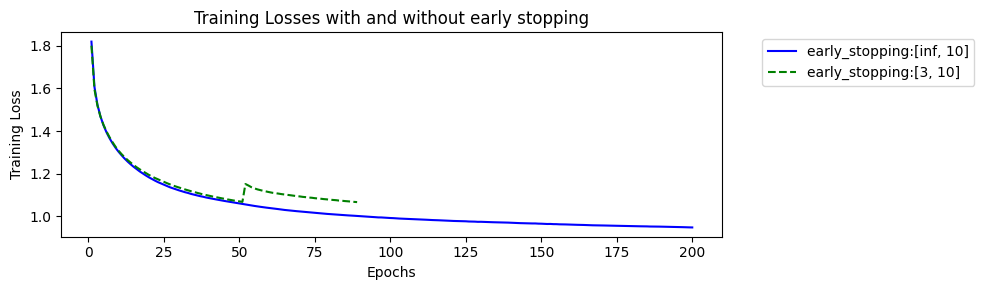

In [ ]:
#plot output
target ='train_loss'
label_keys =['early_stopping']  
marker_param = None
line_param = 'early_stopping'
color_param = 'early_stopping'
title = 'Training Losses with and without early stopping'
multi_plotter(title, assets_exp_1, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

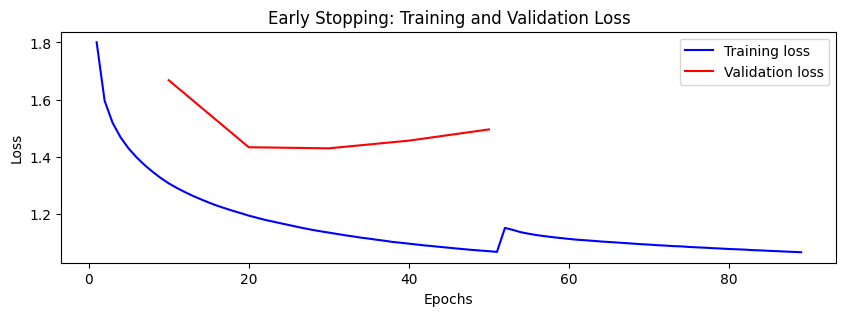

In [ ]:
#plot train and val loss from early stopping
title = 'Early Stopping: Training and Validation Loss'
plot_loss_train_val(assets_exp_1[1]['train_loss'], assets_exp_1[1]['val_loss'],val_loss_interval= 10, fig_size=(10,3), title=title)

### Experiment 2: batch sizes and learning rates

In [ ]:
#hyperparameters
learning_rates = [0.001, 0.01]
batch_sizes = [1, 50, 100]
early_stopping_combination = [[3,10]]
epoch_counts = [100]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.0]
batchnorm_switches = [False]
adam_learning_rates = [0.00]
node_counts = [[128,64,64,10]] 
node_activations = [[None,'relu','relu','softmax']]

parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

#hyperparameter testing
assets_exp_2 = hyperparamater_testing(parameters)

#produce output
columns_to_show =['batch_size','learning_rate','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_2, columns_to_show=columns_to_show)

Running 6 cases.


,momentum_gamma,batch_size,learning_rate,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,0.0,1,0.001,0.61,0.61,0.50,0.49,62,5m45s
1,0.9,1,0.001,0.50,0.52,0.40,0.41,201,21m38s
2,0.0,50,0.001,0.62,0.61,0.50,0.50,86,0m43s
3,0.9,50,0.001,0.51,0.52,0.41,0.41,201,22m27s
4,0.0,100,0.001,0.61,0.61,0.50,0.50,66,18m12s
5,0.9,100,0.001,0.53,0.54,0.43,0.44,201,47m36s


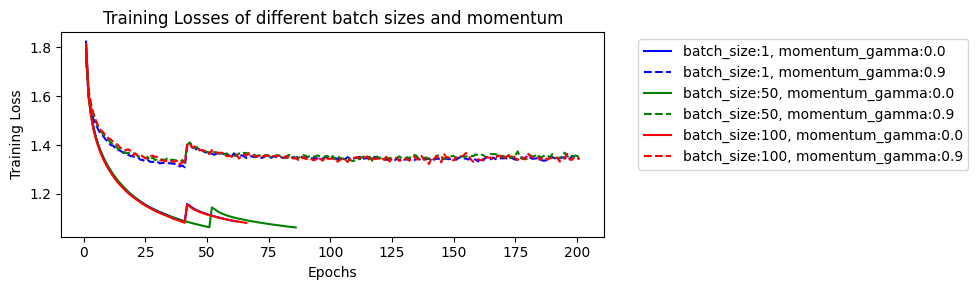

In [ ]:
#plot loss
target ='train_loss'
label_keys =['batch_size', 'learning_rate']  
marker_param = None
line_param = 'learning_rate'
color_param = 'batch_size'
title = 'Training Losses of different batch sizes and learning rates'

multi_plotter(title, assets_exp_2, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

### Experiment 3: dropout and leaky relu

In [ ]:
#hyperparameters
learning_rates = [0.001]
batch_sizes = [100]
early_stopping_combination = [[3,10]]
epoch_counts = [100]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.0, 0.5]
batchnorm_switches = [False]
adam_learning_rates = [0.00]
node_counts = [[128,64,64,10],
               [128,64,64,10]] 
node_activations = [[None,'relu','relu','softmax'],
                    [None,'lrelu','lrelu','softmax']]

parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

#hyperparameter testing
assets_exp_3 = hyperparamater_testing(parameters)

#produce output
columns_to_show =['node_activation','dropout_rate','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_3, columns_to_show=columns_to_show)

Running 6 cases.


,node_activation,dropout_rate,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,"[None, relu, relu, softmax]",0.0,0.62,0.61,0.50,0.49,87,8m57s
1,"[None, lrelu, lrelu, softmax]",0.0,0.61,0.61,0.50,0.50,64,27m4s
2,"[None, relu, relu, softmax]",0.2,0.50,0.50,0.44,0.44,201,85m47s
3,"[None, lrelu, lrelu, softmax]",0.2,0.54,0.53,0.49,0.48,201,78m32s
4,"[None, relu, relu, softmax]",0.5,0.41,0.42,0.39,0.39,200,81m10s
5,"[None, lrelu, lrelu, softmax]",0.5,0.34,0.34,0.35,0.35,42,9m13s


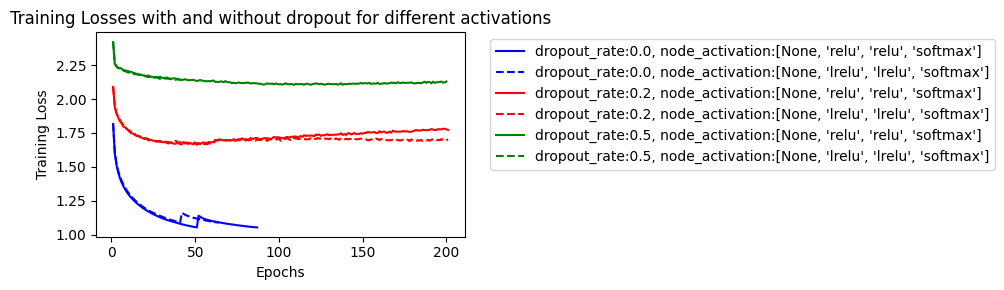

In [ ]:
#plot loss
target ='train_loss'
label_keys =['dropout_rate', 'node_activation']  
marker_param = None
line_param = 'node_activation'
color_param = 'dropout_rate'
title = 'Training Losses with and without dropout for different activations'

multi_plotter(title, assets_exp_3, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

### Experiment 4: deeper and wider networks 

In [ ]:
#hyperparameter testing
learning_rates = [0.001]
batch_sizes = [100]
early_stopping_combination = [[3,10]]
epoch_counts = [100]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.0]
batchnorm_switches = [False]
adam_learning_rates = [0.00]
node_counts = [[128,32,10],
               [128,32,32,10],
               [128,32,32,32,10],
               [128,32,32,32,32,10],
               [128,64,10],
               [128,64,64,10],
               [128,64,64,64,10],
               [128,64,64,64,64,10]] 

node_activations = [[None,'relu','softmax'],
                    [None,'relu','relu','softmax'],
                    [None,'relu','relu','relu','softmax'],
                    [None,'relu','relu','relu','relu','softmax'],
                    [None,'relu','softmax'],
                    [None,'relu','relu','softmax'],
                    [None,'relu','relu','relu','softmax'],
                    [None,'relu','relu','relu','relu','softmax']]

parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

#hyperparameter testing
assets_exp_4 = hyperparamater_testing(parameters)

#produce output
columns_to_show =['node_count', 'train_loss','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_4, columns_to_show=columns_to_show)

Running 8 cases.


,node_count,train_loss,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,"[128, 32, 10]",1.32,0.53,0.53,0.50,0.50,93,0m15s
1,"[128, 32, 32, 10]",1.25,0.56,0.55,0.50,0.50,157,0m29s
2,"[128, 32, 32, 32, 10]",1.24,0.55,0.55,0.49,0.49,99,0m25s
3,"[128, 32, 32, 32, 32, 10]",1.25,0.55,0.55,0.48,0.48,80,0m20s
4,"[128, 64, 10]",1.17,0.59,0.59,0.51,0.51,109,0m22s
5,"[128, 64, 64, 10]",1.06,0.61,0.61,0.50,0.50,85,0m30s
6,"[128, 64, 64, 64, 10]",1.03,0.61,0.60,0.49,0.48,65,0m31s
7,"[128, 64, 64, 64, 64, 10]",1.01,0.59,0.59,0.47,0.46,63,0m53s


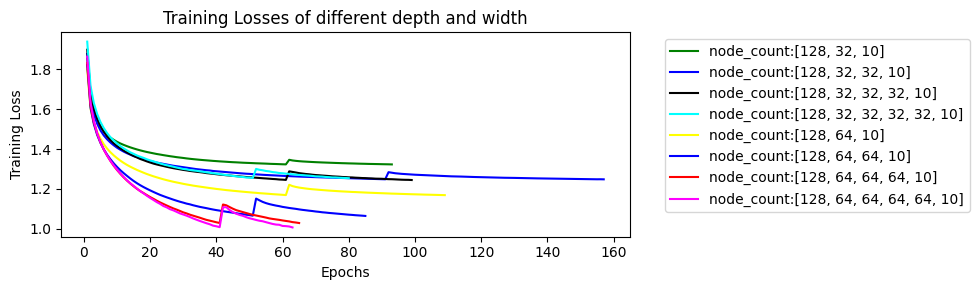

In [ ]:
#plot loss
target ='train_loss'
label_keys =['node_count']  
marker_param = None
line_param = None
color_param = 'node_count'
title = 'Training Losses of different depth and width'

multi_plotter(title, assets_exp_4, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

### Experiment 5: batchnorm and weight decay

In [ ]:
#hyperparameter testing
learning_rates = [0.001]
batch_sizes = [100]
early_stopping_combination = [[3,10]]
epoch_counts = [100]
momentum_gammas = [0.0]
weight_decays = [0.0, 0.01]
dropouts = [0.0]
batchnorm_switches = [True, False]
adam_learning_rates = [0.00]
node_counts = [[128,64,64,10]] 
node_activations = [[None,'relu','relu','softmax']]

parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

#hyperparameter testing
assets_exp_5 = hyperparamater_testing(parameters)

#produce output
columns_to_show =['batchnorm_switch', 'weight_decay','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_5, columns_to_show=columns_to_show)

Running 4 cases.


,batchnorm_switch,weight_decay,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,True,0.00,0.61,0.61,0.52,0.52,64,0m55s
1,False,0.00,0.62,0.62,0.50,0.50,85,0m43s
2,True,0.01,0.62,0.62,0.52,0.51,83,1m13s
3,False,0.01,0.61,0.61,0.49,0.49,86,0m40s


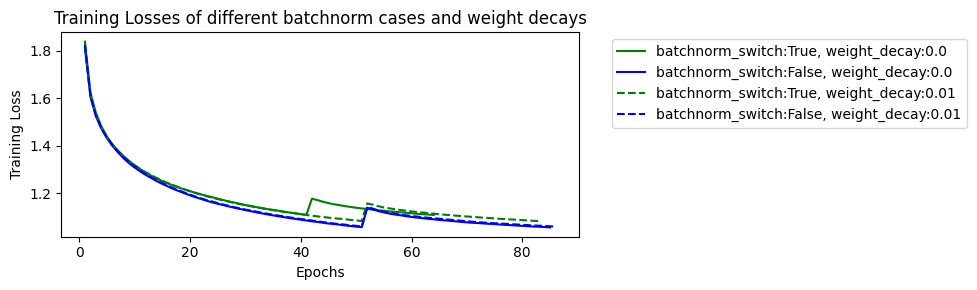

In [ ]:
#plot loss
target ='train_loss'
label_keys =['batchnorm_switch','weight_decay']  
marker_param = None
line_param = 'weight_decay'
color_param = 'batchnorm_switch'
title = 'Training Losses of different batchnorm cases and weight decays'

multi_plotter(title, assets_exp_5, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

### Experiment 6: adam

In [ ]:
#hyperparameter testing
learning_rates = [0.001]
batch_sizes = [100]
early_stopping_combination = [[3,10]]
epoch_counts = [100]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.0]
batchnorm_switches = [True]
adam_learning_rates = [0.0, 0.01, 0.001]
node_counts = [[128,64,64,10]] 
node_activations = [[None,'relu','relu','softmax']]

parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

#hyperparameter testing
assets_exp_6 = hyperparamater_testing(parameters)

#produce output
columns_to_show =['adam_learning_rate','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_6, columns_to_show=columns_to_show)

Running 3 cases.


,adam_learning_rate,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,0.000,0.61,0.60,0.52,0.52,66,1m0s
1,0.010,0.64,0.64,0.51,0.51,93,12m42s
2,0.001,0.63,0.63,0.50,0.50,102,6m17s


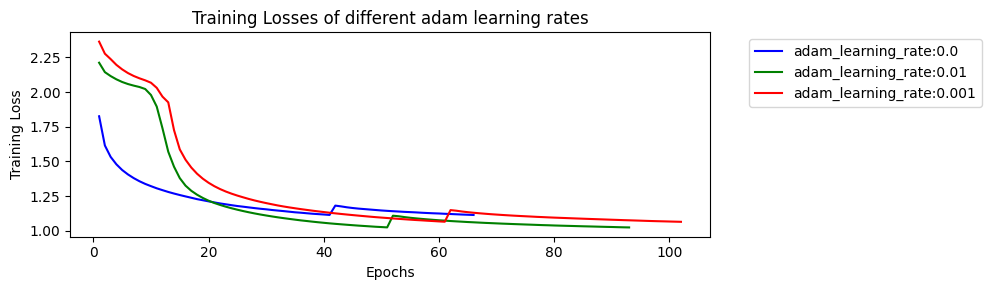

In [ ]:
#plot loss
target ='train_loss'
label_keys =['adam_learning_rate']  
marker_param = None
line_param = None
color_param = 'adam_learning_rate'
title = 'Training Losses of different adam learning rates'

multi_plotter(title, assets_exp_6, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

### Experiment 7: Hyperparameter tuning of best model

In [ ]:
#hyperparameter testing
learning_rates = [0.001, 0.01]
batch_sizes = [50,100,150]
early_stopping_combination = [[3,10]]
epoch_counts = [100]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.0]
batchnorm_switches = [True]
adam_learning_rates = [0.0]
node_counts = [[128,64,64,10],
               [128,64,64,64,10]] 

node_activations = [[None,'relu','relu','softmax'],
                    [None,'relu','relu','relu','softmax']]

parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

#hyperparameter testing
assets_exp_7 = hyperparamater_testing(parameters)

#produce output
columns_to_show =['node_activation','batch_size','node_count','learning_rate','weight_decay','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_7, columns_to_show=columns_to_show)

Running 12 cases.


,node_activation,batch_size,node_count,learning_rate,weight_decay,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,"[None, relu, relu, softmax]",50,"[128, 64, 64, 10]",0.001,0.0,0.60,0.59,0.52,0.51,61,9m0s
1,"[None, relu, relu, relu, softmax]",50,"[128, 64, 64, 64, 10]",0.001,0.0,0.60,0.59,0.49,0.49,65,0m55s
2,"[None, relu, relu, softmax]",50,"[128, 64, 64, 10]",0.010,0.0,0.61,0.61,0.52,0.52,70,0m49s
3,"[None, relu, relu, relu, softmax]",50,"[128, 64, 64, 64, 10]",0.010,0.0,0.61,0.61,0.51,0.50,71,6m55s
4,"[None, relu, relu, softmax]",100,"[128, 64, 64, 10]",0.001,0.0,0.61,0.61,0.51,0.51,65,1m15s
5,"[None, relu, relu, relu, softmax]",100,"[128, 64, 64, 64, 10]",0.001,0.0,0.61,0.61,0.50,0.49,65,1m18s
6,"[None, relu, relu, softmax]",100,"[128, 64, 64, 10]",0.010,0.0,0.62,0.62,0.52,0.52,74,1m23s
7,"[None, relu, relu, relu, softmax]",100,"[128, 64, 64, 64, 10]",0.010,0.0,0.62,0.62,0.50,0.50,73,1m31s
8,"[None, relu, relu, softmax]",150,"[128, 64, 64, 10]",0.001,0.0,0.61,0.61,0.51,0.51,63,0m38s
9,"[None, relu, relu, relu, softmax]",150,"[128, 64, 64, 64, 10]",0.001,0.0,0.61,0.61,0.50,0.50,64,29m8s


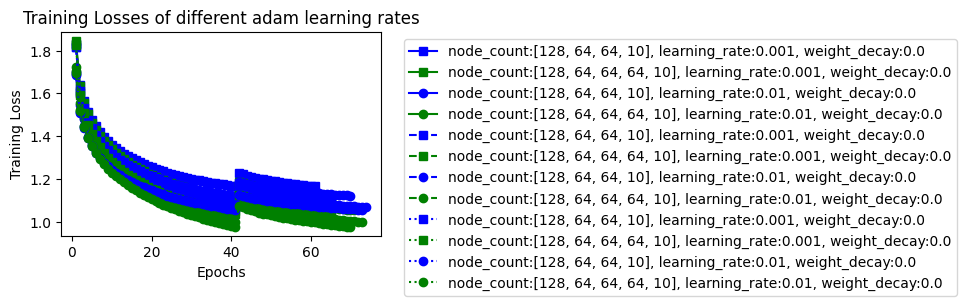

In [ ]:
#plot loss
target ='train_loss'
label_keys =['node_count','learning_rate','weight_decay']  
marker_param = 'learning_rate'
line_param = 'batch_size'
color_param = 'node_count'
title = 'Training Losses of different adam learning rates'

multi_plotter(title, assets_exp_7, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

In [ ]:
#filter output
columns_to_show =['node_count','learning_rate','batch_size','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
assets_exp_7_filtered_1 = filter_asset(assets_exp_7, filter_key = 'node_count', filter_value = [128, 64, 64, 10], columns_to_show = columns_to_show)
assets_exp_7_filtered_1

,node_count,learning_rate,batch_size,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,"[128, 64, 64, 10]",0.001,50,0.60,0.59,0.52,0.51,61,9m0s
2,"[128, 64, 64, 10]",0.010,50,0.61,0.61,0.52,0.52,70,0m49s
4,"[128, 64, 64, 10]",0.001,100,0.61,0.61,0.51,0.51,65,1m15s
6,"[128, 64, 64, 10]",0.010,100,0.62,0.62,0.52,0.52,74,1m23s
8,"[128, 64, 64, 10]",0.001,150,0.61,0.61,0.51,0.51,63,0m38s
10,"[128, 64, 64, 10]",0.010,150,0.62,0.62,0.52,0.51,73,14m16s


In [ ]:
#filter output
columns_to_show =['node_count','learning_rate','batch_size','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
assets_exp_7_filtered_2 = filter_asset(assets_exp_7, filter_key = 'node_count', filter_value = [128, 64, 64, 64, 10], columns_to_show = columns_to_show)
assets_exp_7_filtered_2

,node_count,learning_rate,batch_size,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
1,"[128, 64, 64, 64, 10]",0.001,50,0.60,0.59,0.49,0.49,65,0m55s
3,"[128, 64, 64, 64, 10]",0.010,50,0.61,0.61,0.51,0.50,71,6m55s
5,"[128, 64, 64, 64, 10]",0.001,100,0.61,0.61,0.50,0.49,65,1m18s
7,"[128, 64, 64, 64, 10]",0.010,100,0.62,0.62,0.50,0.50,73,1m31s
9,"[128, 64, 64, 64, 10]",0.001,150,0.61,0.61,0.50,0.50,64,29m8s
11,"[128, 64, 64, 64, 10]",0.010,150,0.62,0.62,0.50,0.49,70,1m34s
